In [3]:
# Standard Imports
from __future__ import print_function
import numpy as np
import pandas as pd
import os
import sys
from collections import defaultdict
from importlib import reload
from bs4 import BeautifulSoup
import requests
import scipy.stats as scs
import time
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Modeling
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
import keras.backend as K
from tensorflow.keras.constraints import min_max_norm, non_neg
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load MongoDB
from pymongo import MongoClient
client = MongoClient()
# Access/Initiate Database
db = client['producer_db']
# Access/Initiate Table
mfcc_tab = db['mfcc']
mfcc_collection = db.mfcc_tab

# Authorize Spotify API
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
client_id = os.environ['SPOTIFY_CLIENT_ID']
client_secret = os.environ['SPOTIFY_CLIENT_SECRET']
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

# # Audio Processing
# import librosa
# import librosa.display
# from IPython.display import Audio
# from scipy.io import wavfile
# from pydub import AudioSegment
# from src.audio_processing import load_mp3_from_url

Using TensorFlow backend.


In [2]:
model = models.Sequential()

# model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(20, 1292, 1)))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# # model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten(input_shape = (20,1292,1)))
# model.add(layers.Dense(64, activation='relu'))
# model.add(layers.Dense(32, activation='relu'))
# model.add(layers.Dense(12, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

# model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# model.add(layers.Flatten())
# model.add(layers.Dense(64, activation='relu'))
# model.add(layers.Dense(10, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.


In [4]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 25840)             0         
_________________________________________________________________
dense (Dense)                (None, 10)                258410    
Total params: 258,410
Trainable params: 258,410
Non-trainable params: 0
_________________________________________________________________


In [5]:
def mfcc_train_test(collection, test_size = 0.25, random_state = 440):
    """
    Inputs:
        collection: Mongo DB collection
        test_size: between 0 and 1, fraction of data in test set.
        random_state: random state for sklearn train_test_split
        
    Outputs:
        X_train, X_test, y_train, y_test, y_columns
        y_columns is the labels associated with the columns of y
    """
    X = []
    y = []
                    
    for song in collection.find():
        if np.array(song['MFCC']).shape[1] >= 1292:
            X.append(np.array(song['MFCC'])[:,:1292].flatten())
            y.append(song['producer'])
        
    
    #NEED TO STACK LIST OF MFCCS 
    X = np.vstack(X)
    y = np.array(y)
    
    y_one_hot = pd.get_dummies(y).values
    y_columns = pd.get_dummies(y).columns
#     X = X.reshape(-1,20,1292,1)
    
    X_train, X_test, y_train, y_test = train_test_split(X ,y_one_hot, test_size = test_size, random_state = random_state)
    
    return X_train, X_test, y_train, y_test, y_columns

In [6]:
X_train, X_test, y_train, y_test, y_columns = mfcc_train_test(mfcc_collection, test_size = 0.25, random_state = 440)

In [7]:
X_train.shape

(745, 25840)

In [8]:
# Standardize
ss = StandardScaler()
X_train_scale = ss.fit_transform(X_train)
X_test_scale = ss.transform(X_test)

In [9]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
#WHY IS THIS NOT RUNNING?

model.fit(X_train_scale.reshape(-1,20,1292,1), y_train, epochs=20)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20


# This method makes the kernel crash. Let's use PCA to reduce the dimensionality:

### First get data into X (features) and y (target)

In [1]:
X = []
y = []

for song in mfcc_collection.find():
    if np.array(song['MFCC']).shape[1] >= 1292:
        X.append(np.array(song['MFCC'])[:,:1292].flatten())
        y.append(song['producer'])


#NEED TO STACK LIST OF MFCCS 
X = np.vstack(X)
y = np.array(y)

y_one_hot = pd.get_dummies(y).values
y_columns = np.array(pd.get_dummies(y).columns)

NameError: name 'mfcc_collection' is not defined

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X ,y_one_hot, test_size = 0.3, random_state = 440)

# Standardize
ss = StandardScaler()
X_train_scale = ss.fit_transform(X_train)
X_test_scale = ss.transform(X_test)

from sklearn.decomposition import PCA

pca = PCA(n_components=100)

X_train_pca = pca.fit_transform(X_train_scale)
X_test_pca = pca.transform(X_test_scale)

### Make a scree plot:

In [7]:
def scree_plot(ax, pca, n_components_to_plot=8, title=None):
    """Make a scree plot showing the variance explained (i.e. varaince of the projections) for the principal components in a fit sklearn PCA object.
    
    Parameters
    ----------
    ax: matplotlib.axis object
      The axis to make the scree plot on.
      
    pca: sklearn.decomposition.PCA object.
      A fit PCA object.
      
    n_components_to_plot: int
      The number of principal components to display in the skree plot.
      
    title: str
      A title for the skree plot.
    """
    num_components = pca.n_components_
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
    ax.plot(ind, vals, color='blue')
    ax.scatter(ind, vals, color='blue', s=50)

    for i in range(num_components):
        ax.annotate(r"{:2.2f}%".format(vals[i]), 
                   (ind[i]+0.2, vals[i]+0.005), 
                   va="bottom", 
                   ha="center", 
                   fontsize=12)

    ax.set_xticklabels(ind, fontsize=12)
    ax.set_ylim(0, max(vals) + 0.05)
    ax.set_xlim(0 - 0.45, n_components_to_plot + 0.45)
    ax.set_xlabel("Principal Component", fontsize=12)
    ax.set_ylabel("Variance Explained (%)", fontsize=12)
    if title is not None:
        ax.set_title(title, fontsize=16)

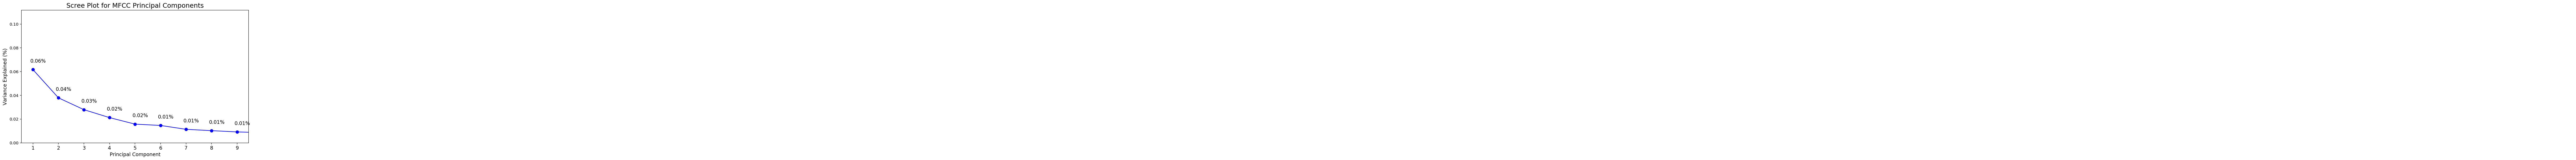

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))
scree_plot(ax, pca, title="Scree Plot for MFCC Principal Components")

In [9]:
X_train_pca.shape

(695, 100)

### Train a nearest neighbors model

In [25]:
def plot_mnist_embedding(ax, X, y, title=None, alpha = 1):
    """Plot an embedding of the mnist dataset onto a plane.
    
    Parameters
    ----------
    ax: matplotlib.axis object
      The axis to make the scree plot on.
      
    X: numpy.array, shape (n, 2)
      A two dimensional array containing the coordinates of the embedding.
      
    y: numpy.array
      The labels of the datapoints.  Should be digits.
      
    title: str
      A title for the plot.
    """
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)
    ax.axis('off')
    ax.patch.set_visible(False)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], 
                 str(y[i]), 
                 color=plt.cm.Set1((y[i]+1) / 10.), 
                 fontdict={'weight': 'bold', 'size': 12},
                 alpha = alpha)

    ax.set_xticks([]), 
    ax.set_yticks([])
    ax.set_ylim([-0.1,1.1])
    ax.set_xlim([-0.1,1.1])

    if title is not None:
        ax.set_title(title, fontsize=16)

In [26]:
np.argmax(np.array([[0,1,0]]),axis=0)

array([0, 0, 0])

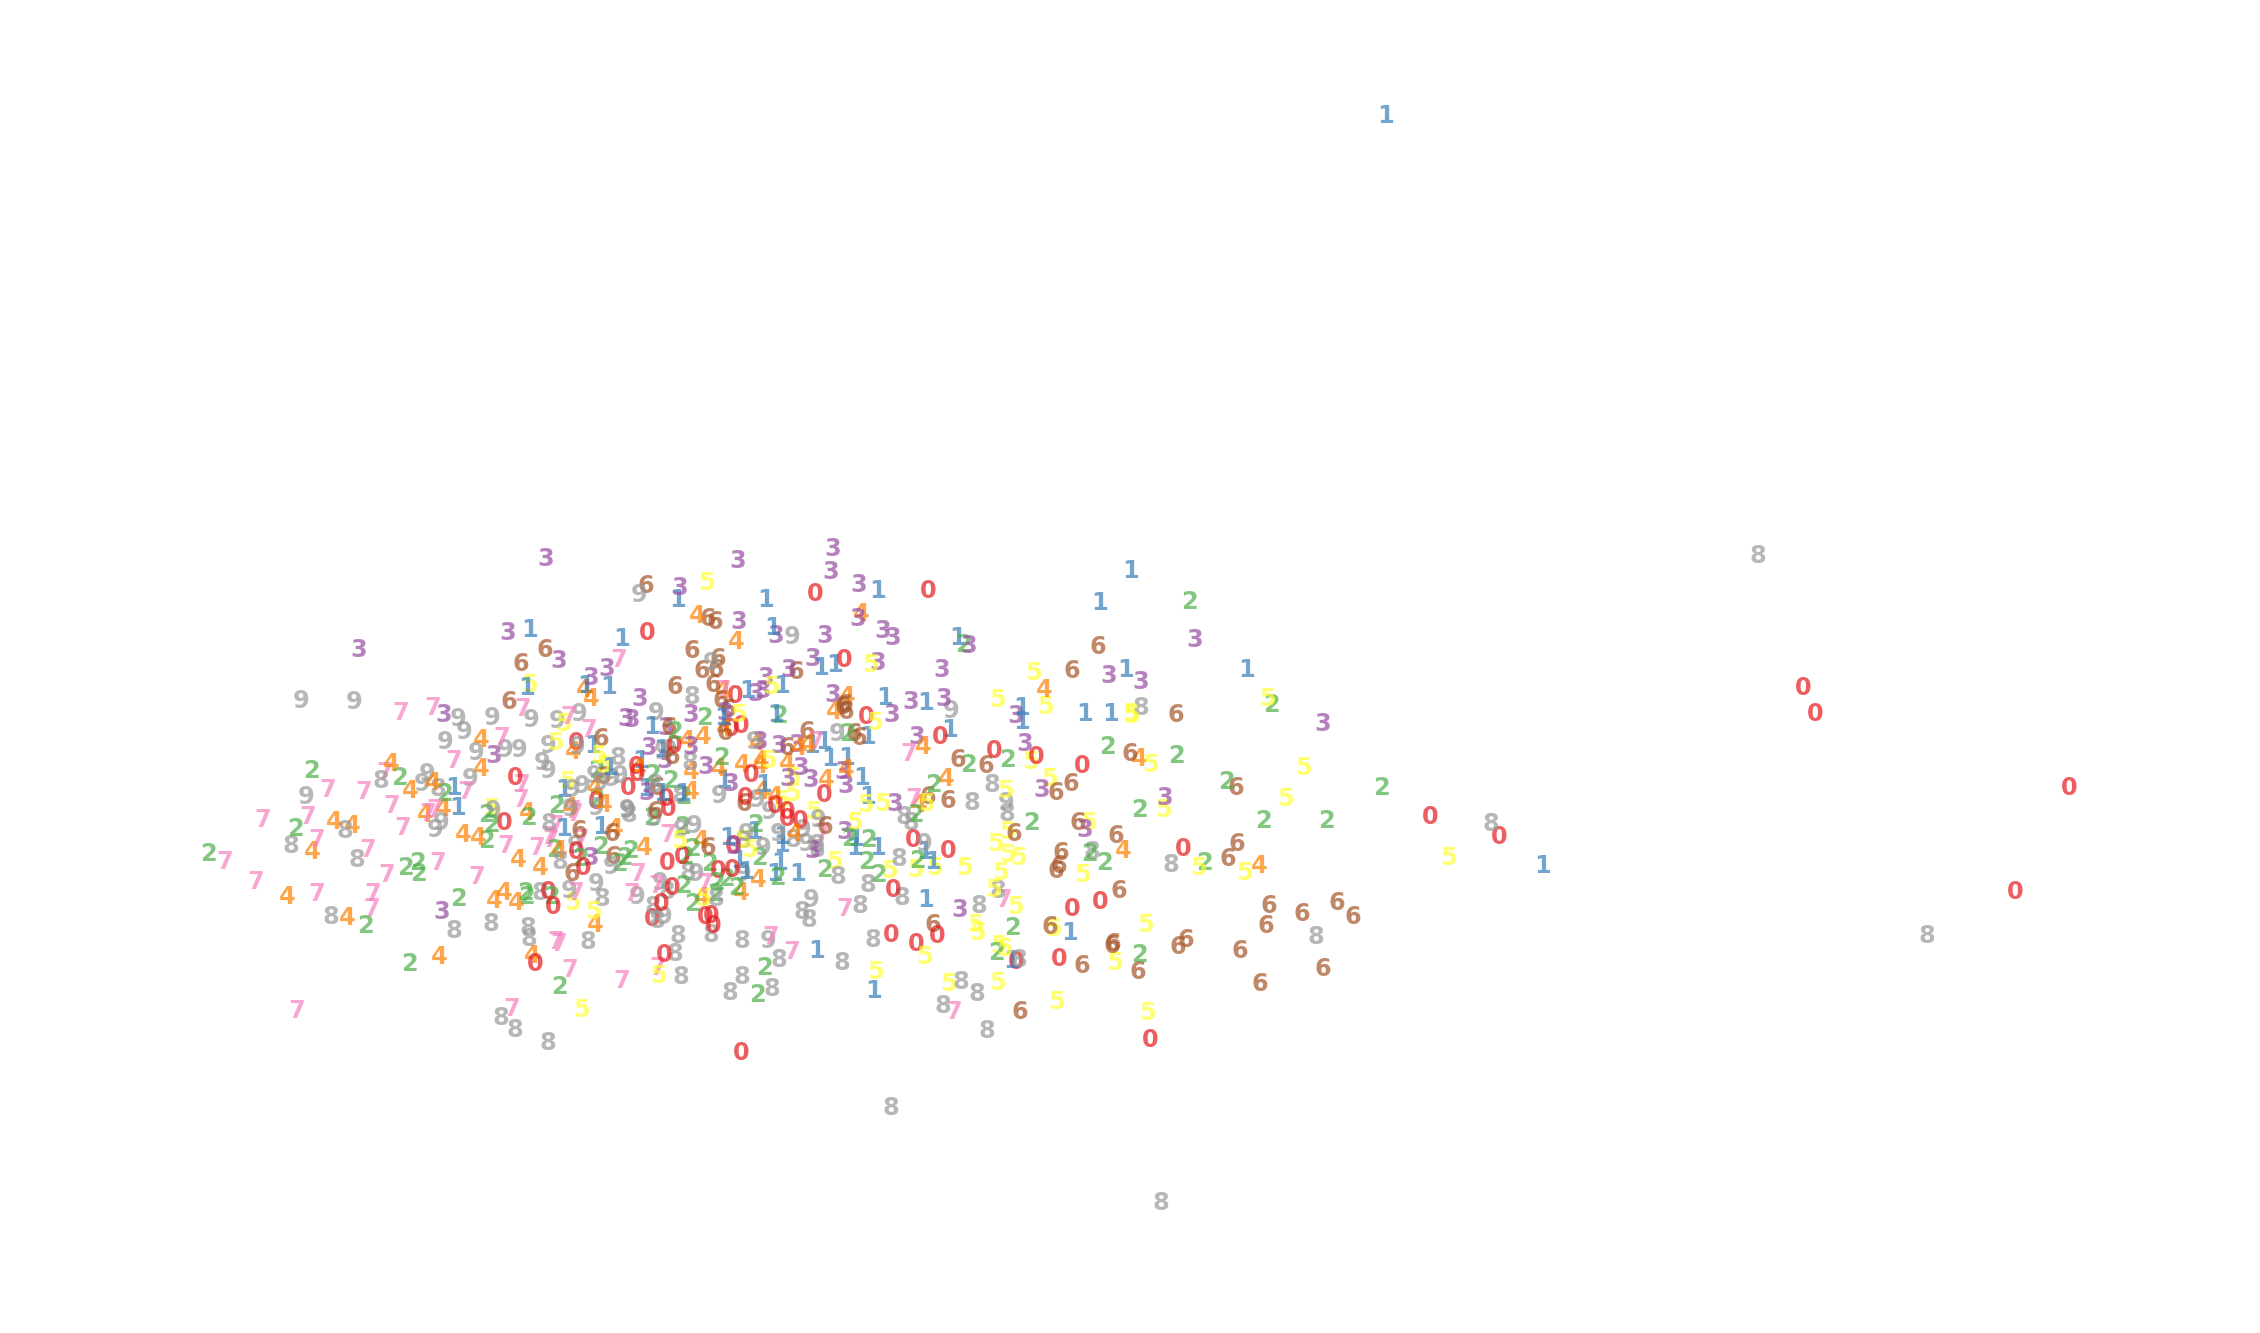

In [30]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_train_scale)


fig, ax = plt.subplots(figsize=(20, 12))
plot_mnist_embedding(ax, X_pca[:,1:], np.argmax(y_train, axis = 1), alpha = 0.7)

In [1]:
import seaborn as sns

In [12]:
X_train_scale.shape, np.argmax(y_train, axis = 1).reshape(-1,1).shape

((695, 25840), (695, 1))

In [19]:
y_columns = np.array(y_columns)

In [16]:
y_columns[np.argmax(y_train, axis = 1)]

Index(['Dr. Dre', 'Stock Aitken Waterman', 'Dr. Dre', 'Pete Rock',
       'Kanye West', 'Dr. Dre', 'Paul Epworth', 'Paul Epworth', 'Rick Rubin',
       'Dr. Dre',
       ...
       'Pete Rock', 'Roy Thomas Baker', 'Paul Epworth', 'Brian Eno',
       'George Martin', 'Paul Epworth', 'Pete Rock', 'George Martin',
       'George Martin', 'Brian Eno'],
      dtype='object', length=695)

In [37]:
X_train_scale.shape

(695, 25840)

/Users/Maxwell/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


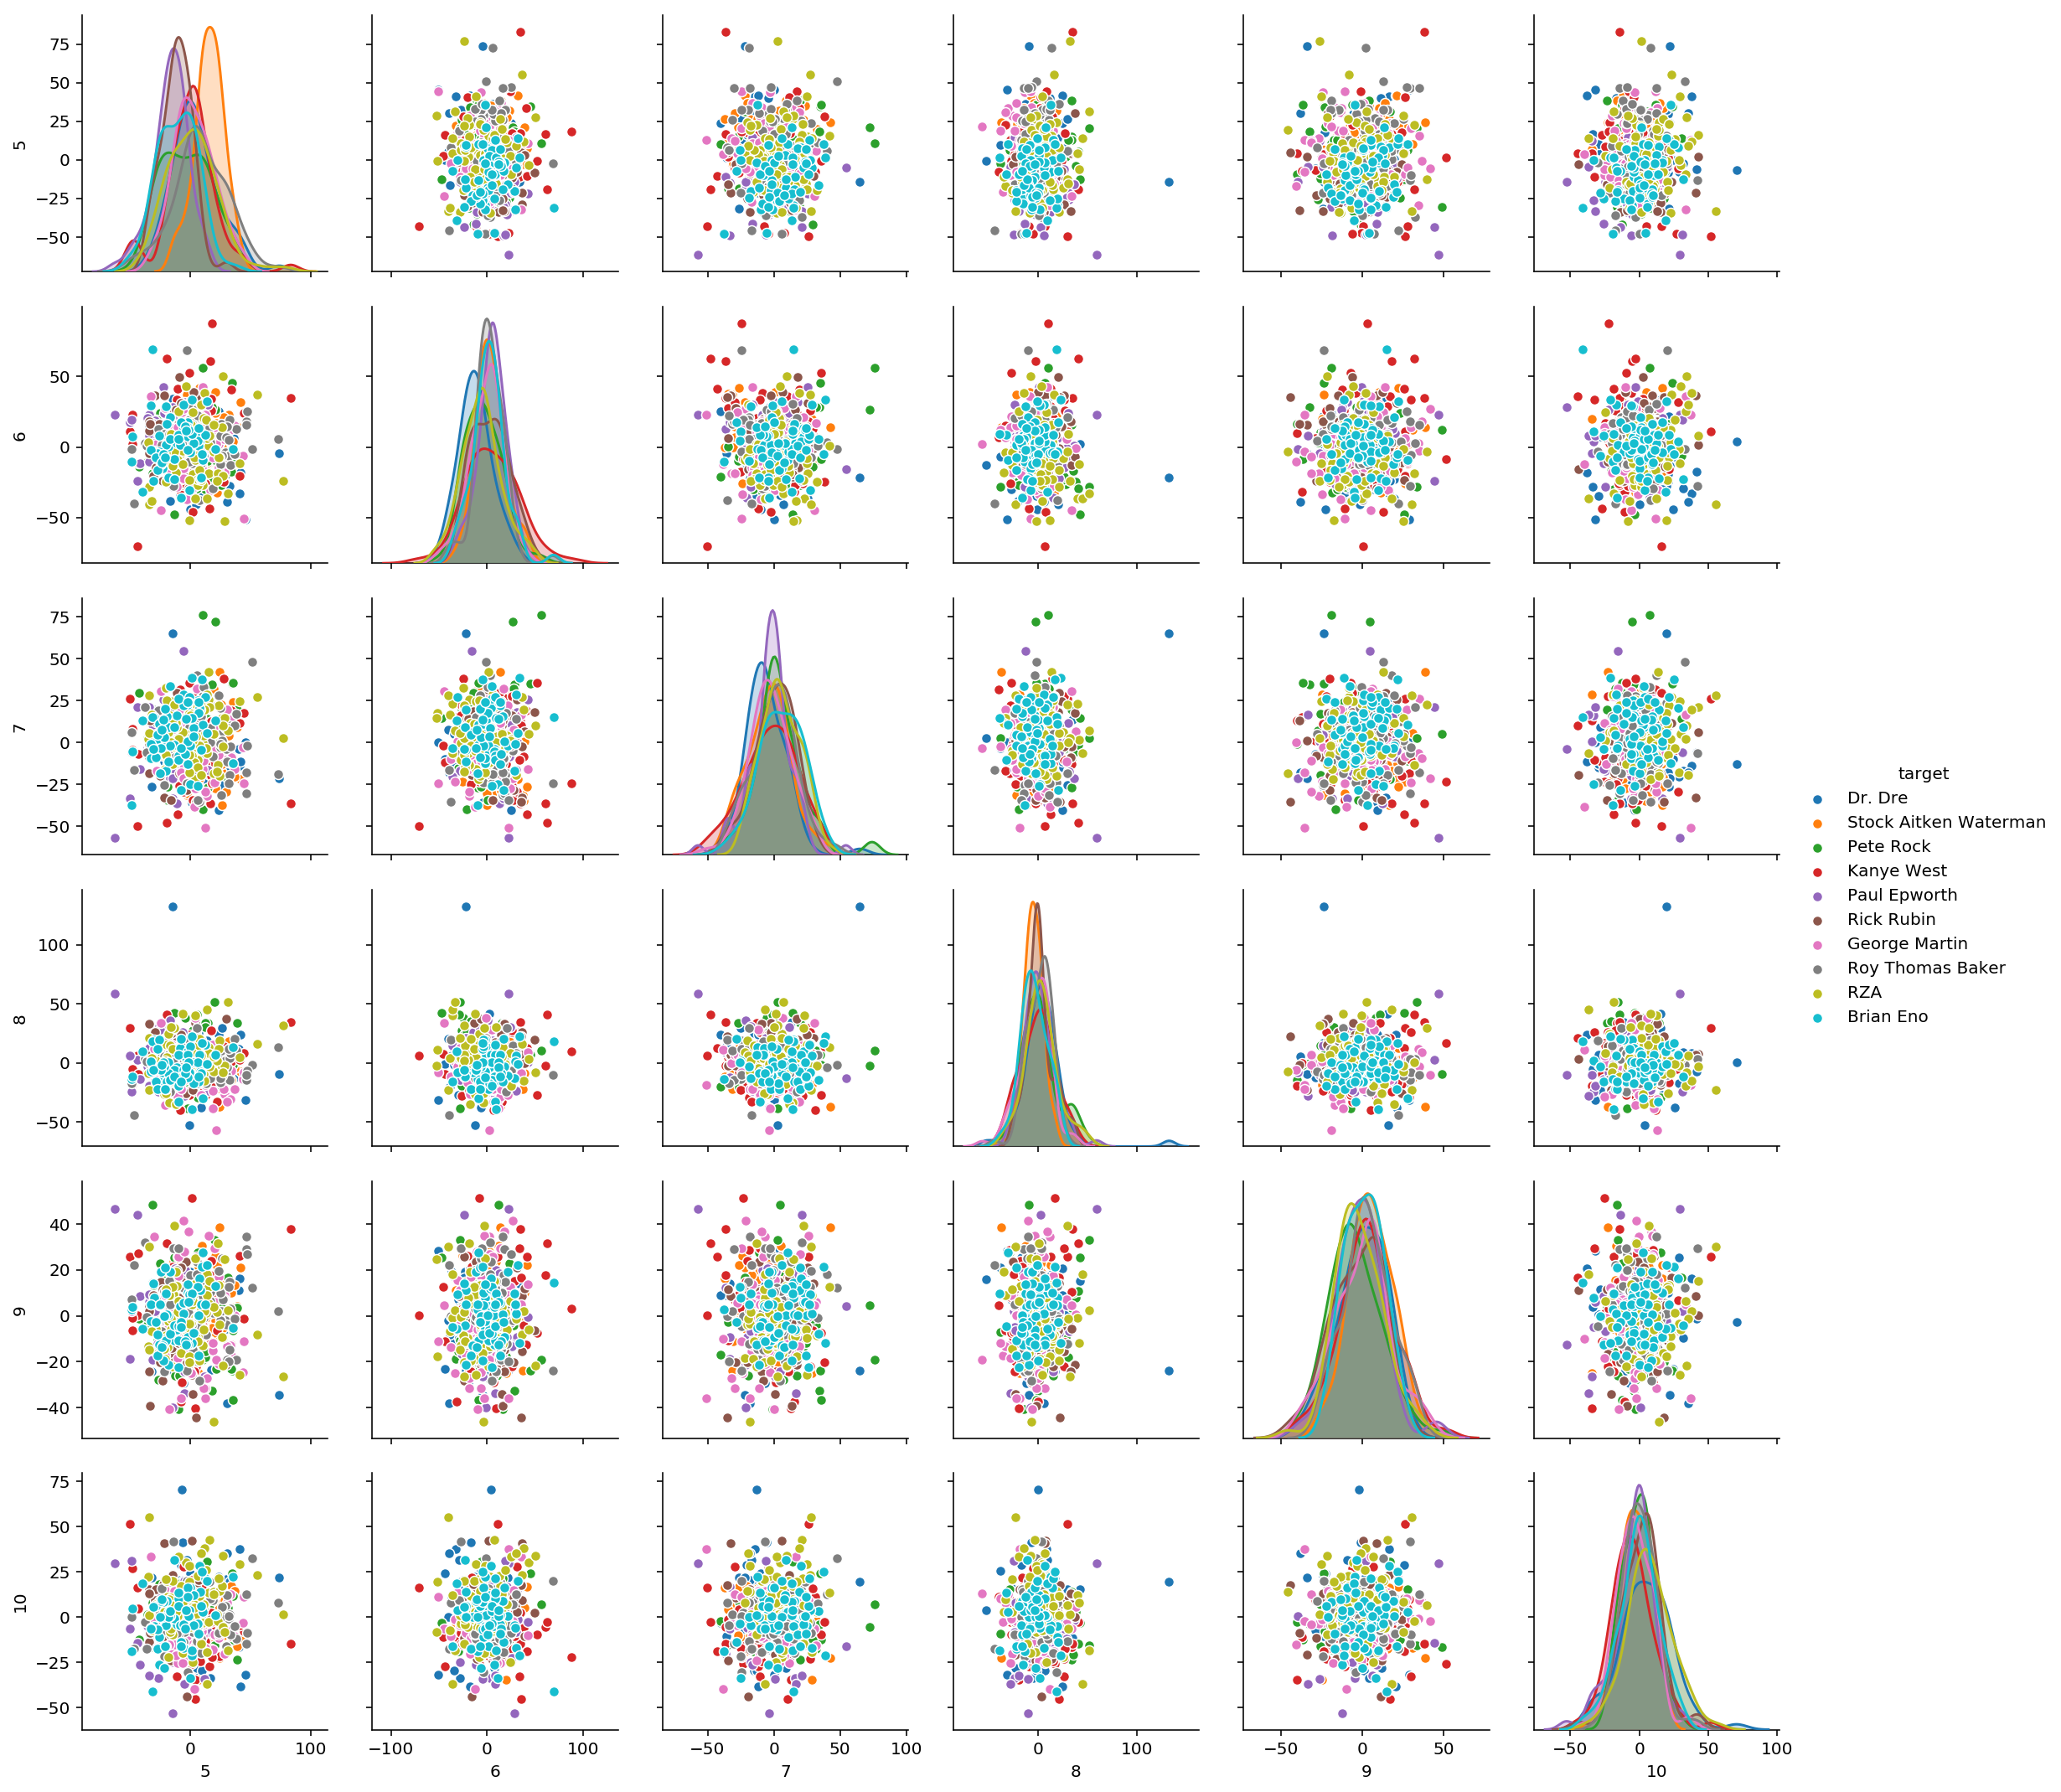

In [39]:
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_train_scale)

X_pca_df = pd.DataFrame(np.concatenate((X_pca, y_columns[np.argmax(y_train, axis = 1)].reshape(-1,1)), axis = 1), columns = [1,2,3,4,5,6,7,8,9,10,'target'])
X_pca_df.head()

# pairwise plot
sns.pairplot(X_pca_df[[5,6,7,8,9,10,'target']], hue = 'target')

This is very difficult to interpret. It looks mostly like noise. Only signal looks like SAW on the kde of feature 5 is higher than most.

In [46]:
model = models.Sequential()

# model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(20, 1292, 1)))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# # model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten(input_shape = (10,)))
# model.add(layers.Dense(64, activation='relu'))
# model.add(layers.Dense(32, activation='relu'))
# model.add(layers.Dense(12, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

# model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# model.add(layers.Flatten())
# model.add(layers.Dense(64, activation='relu'))
# model.add(layers.Dense(10, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
Total params: 110
Trainable params: 110
Non-trainable params: 0
_________________________________________________________________


In [42]:
# Get rid of big variables
del X
del y
del X_train
del X_test

In [47]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(X_pca, y_train, epochs=20)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20


# It looks like MFCC is not a good way to characterize this variable.